# Energy fluxes

The objective of this script is to calculate means and generate plots of the radiative and non-radiative fluxes at the PV field and its desert background

In [1]:
import pandas as pd
import openpyxl
import numpy as np
import glob
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from scipy import signal
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
from scipy import stats
import os
from plotnine.data import mtcars
from functools import reduce
from itertools import product, combinations

### Input and output paths

In [2]:
project_path = './'
input_path   = '../data/'
output_path  = '../data/'

# Functions

In [3]:
def load_data(fn, index_col=False, silent=False):
    if (not silent):
        print('  - Loading', fn.split('/')[-1])
    temp = pd.read_csv(fn, index_col=index_col)
    temp['DateTime'] = pd.to_datetime(temp['DateTime'], format='%Y-%m-%d %H:%M:%S', utc=True)
    return(temp)

def averaging(temp, midday=True):
    # define mid-day
    if(midday):
        temp = temp.loc[(temp['DateTime'].dt.hour >= 10) & (temp['DateTime'].dt.hour < 15)].copy()
    else:
        # Create a Day column
        temp['Day'] = temp['DateTime'].dt.strftime('%Y-%m-%d')
        # Do averaging of the days, and then continue
        temp = temp.groupby(['Season','Ecosystem', 'Day']).mean()
        temp.reset_index(inplace=True)
        pass
        
    # Make mean and std dev
    df_means = temp.groupby(['Season','Ecosystem']).mean().reset_index()
    df_sds   = temp.groupby(['Season','Ecosystem']).std().reset_index()
    
    # Merge
    merged = df_means.merge(df_sds, on=['Season','Ecosystem'])
    
    # Rename columns
    merged.columns = [s.replace('_x', '_mean') if s.endswith('_x') else s for s in merged.columns]
    merged.columns = [s.replace('_y', '_sd') if s.endswith('_y') else s for s in merged.columns]

    
    return(merged)

def diurnal(temp,Ecosystem,Season):
    
    temp = temp.loc[(temp['Ecosystem'] == Ecosystem) & (temp['Season'] == Season)].copy()
    
    # creating 'Time' column
    temp['Time'] = temp['DateTime'].dt.strftime('%H:%M')
    
    # Keep only relevant columns
    temp = temp[['Time','Ecosystem','Lout']]
    
    # Make mean and std dev
    df_means = temp.groupby(['Ecosystem','Time']).mean().reset_index()
    df_sds   = temp.groupby(['Ecosystem','Time']).std().reset_index()
    
    merged = df_means.merge(df_sds, on=['Ecosystem','Time'])
    
    # Rename columns
    merged.columns = [s.replace('_x', '_mean') if s.endswith('_x') else s for s in merged.columns]
    merged.columns = [s.replace('_y', '_sd') if s.endswith('_y') else s for s in merged.columns]
    
    return(merged)

def diurnal_averaging(temp):
    temp = temp.copy()
    
    temp['Time'] = temp['DateTime'].dt.strftime('%H:%M')
    
    diurnal_df = temp.groupby(['Season', 'Ecosystem', 'Time']).agg(['mean', 'std'])
    diurnal_df.reset_index(inplace=True)
    diurnal_df.columns = ['_'.join(col).strip('_') for col in diurnal_df.columns]
    
    return(diurnal_df)

def daily_averaging_diurnal(temp):
    daily_df = temp.groupby(['Season', 'Ecosystem']).mean()
    daily_df.reset_index(inplace=True)
    return(daily_df)

def pvalue_text(p):
    if(p <= 0.001): p_text = '<.001'
    if(p > 0.001): p_text = '<.01'
    if(p > 0.01): p_text = '<.05'
    if(p > 0.05): p_text = p.round(2).astype(str)
    if(np.isnan(p)): p_text = 'N/A'
    return(p_text)

def ttest_all(temp, category, list_of_test_cols, group_col):
    # Prepare name of categories to test against each other
    group1 = temp[group_col].unique()[0]
    group2 = temp[group_col].unique()[1]
    print('Testing', group1, '&', group2)
    
    # Prepare df for results
    out_df = pd.DataFrame(list(product(list_of_test_cols, temp[category].dropna().unique())), columns=['Parameter', category])
    out_df['p'] = np.nan
    
    # Do t-tests for all combinations
    for col in list_of_test_cols:
        #print('----')
        #print(col)
        for cat in temp[category].dropna().unique():
            #print(cat)
            a = temp.loc[(temp[group_col] == group1) & (temp[category] == cat),col]
            b = temp.loc[(temp[group_col] == group2) & (temp[category] == cat),col]
            t = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit') # Welch t-test for inequal variances
            print(col, cat, ':', pvalue_text(t[1]))
            # Add data to resulting df
            out_df.loc[(out_df[category] == cat) & (out_df['Parameter'] == col), 'p'] = pvalue_text(t[1])
    
    return(out_df)

def ttest_all2(temp, categories_to_test, list_data_cols, test_type='independent'):
    # Prepare list of lists
    list_of_lists = []
    for cat_i, cat in enumerate(categories_to_test):
        sub_categories = list(temp[cat].unique())
        list_of_lists.append(sub_categories)
    print('All categories:', list_of_lists)
    
    # Count number of categories
    cat_count = len(categories_to_test)
    list_of_dfs = []
    
    # Go through the list of all data columns
    for data_col in list_data_cols:
        print("Testing data column: ", data_col)
        
        # Prepare empty list of lists to fill
        out_list = []
        # List all combinations, and go through
        for i in list(combinations( list(product(*list_of_lists)) , 2)):
            # If no x-1 elements (for 3 categories, that's 2) overlaps, skip
            # This makes sure not to test combinations where everything is different
            # (e.g. Autumn Pines Hamsin vs Spring Maquis Normal)
            if(sum([j in i[0] for j in i[1]]) < (cat_count-1)):
                continue
            #print(i)  # DEBUG
            # Prepare row to append data
            row_list = []
            a_conditions = []
            b_conditions = []
            # Check which elements are the same in each pair
            for j in range(cat_count):
                if(i[0][j] == i[1][j]):
                    #print('Identical columns:', i[0][j]) # DEBUG
                    row_list.append(i[0][j])
                else:
                    #print('Column to test:', categories_to_test[j]) # DEBUG
                    row_list.append('')
                # Create list of conditions
                a_conditions.append(temp[categories_to_test[j]] == i[0][j])
                b_conditions.append(temp[categories_to_test[j]] == i[1][j])
            # Create the text of which 2 variables are being tested against each other
            test_str = list(set(i[0]) - set(i[1]))[0] + ' vs. ' + list(set(i[1]) - set(i[0]))[0]
            row_list.append(test_str)
            # Prepare t-test
            a = temp.loc[reduce(np.logical_and, a_conditions), data_col]
            b = temp.loc[reduce(np.logical_and, b_conditions), data_col]
            if(test_type == 'independent'):
                t = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit') # Welch t-test for inequal variances
            else:
                t = stats.ttest_rel(a, b, nan_policy='omit') # Paired t-test
            #row_list.append(t[1]) # Full P value
            row_list.append(pvalue_text(t[1])) # P value as text
            # Add p values to final output
            out_list.append(row_list)
    
        # Column names
        colnames = categories_to_test + ['Test','P_'+data_col]
        out_df = pd.DataFrame(out_list, columns=colnames)
        list_of_dfs.append(out_df)
    
    # Finally merge all
    final_df = reduce(lambda df1,df2: pd.merge(df1,df2, on=categories_to_test + ['Test']), list_of_dfs)
    print('Done...')
    
    return(final_df)

def ttest_2vars(temp, groups, vars_to_test, test_type='paired'):
    grouped = temp.groupby(groups)
    list_of_results = []
    for name, group in grouped:
        # Prepare t-test
        a = group[[vars_to_test[0]]]
        b = group[[vars_to_test[1]]]
        # Do the test
        if(test_type == 'paired'):
            t = stats.ttest_rel(a, b, nan_policy='omit') # Paired t-test
        else:
            t = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit') # Welch t-test for inequal variances
        # Append results to output
        current_result = list(name)
        p_val = t[1]
        try:
            p_val = p_val = t[1][0]
        except:
            pass
        current_result.append(pvalue_text(p_val))
        list_of_results.append(current_result)
    # Column names
    colnames = groups + ['P']
    # Create result df
    out_df = pd.DataFrame(list_of_results, columns=colnames)
    return(out_df)

In [4]:
# Load data
df = load_data(input_path + 'dataset.csv')

# Create H + LE + PVe
df.loc[df['Ecosystem'] == 'Afforestation','PVe'] = 0
df['H_LE_PVe'] = df['H'] + df['LE'] + df['PVe']

# Remove the bad 22nd of march 2018
df = df.loc[(df['DateTime'] <= '2018-03-21 23:59') | (df['DateTime'] >= '2018-03-23 00:00')].copy()

display (df)

  - Loading dataset.csv


C:\Users\rafas\Miniconda3\envs\analysis\lib\site-packages\IPython\core\interactiveshell.py:3337: DtypeWarning: Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.


,DateTime,Month,Year,Ecosystem,H,LE,Pa,RH,TA_merge,VPD,...,Lemitted,emissivity,PVe,Rn,Ts,D_T,cp,rho,rH,H_LE_PVe
0,2019-07-10 00:30:00+00:00,July,2019,PV desert background,-18.79140,-2.500320,99081.800,25.52,305.52,3606.03,...,423.670173,0.87,0.0,-92.40201,31.270731,-1.099264,1012.948384,1.083521,64.204776,-21.291720
1,2019-07-10 01:00:00+00:00,July,2019,PV desert background,-7.42804,-6.111050,99077.000,25.76,305.02,3494.33,...,421.319794,0.87,0.0,-92.81302,30.847644,-1.022351,1012.790980,1.086618,151.468532,-13.539090
2,2019-07-10 01:30:00+00:00,July,2019,PV desert background,-16.05200,-3.831300,99064.600,24.80,304.67,3470.02,...,419.386825,0.87,0.0,-93.99899,30.498366,-1.021653,1012.386117,1.088297,70.124219,-19.883300
3,2019-07-10 02:00:00+00:00,July,2019,PV desert background,-12.27440,8.551300,99052.400,24.92,304.17,3367.42,...,417.317094,0.87,0.0,-94.19299,30.123034,-0.896985,1012.210480,1.091237,80.718851,-3.723100
4,2019-07-10 02:30:00+00:00,July,2019,PV desert background,-13.91630,-5.565570,99041.300,26.79,303.69,3194.86,...,415.351335,0.87,0.0,-94.87900,29.765262,-0.774746,1012.480210,1.094591,61.698455,-19.481870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37931,2020-08-31 21:30:00+00:00,August,2020,Afforestation,-9.60000,-16.956398,93209.330,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,1021.611400,1.079329,NaN,-26.556398
37932,2020-08-31 22:00:00+00:00,August,2020,Afforestation,-9.30000,-11.220856,93201.010,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,1021.600486,1.080576,NaN,-20.520856
37933,2020-08-31 22:30:00+00:00,August,2020,Afforestation,-9.60000,22.113760,93188.625,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,1021.426533,1.080792,NaN,12.513760
37934,2020-08-31 23:00:00+00:00,August,2020,Afforestation,NaN,NaN,93180.766,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,1019.405333,1.077225,NaN,NaN


In [5]:
mean_df = averaging(df, midday=True).round(2)

# Move Season to the front
col = mean_df.pop('Season')
mean_df.insert(0, col.name, col)
# Create a text of summarised values (mean + stddev)
mean_df['SWin'] = mean_df['SWin_mean'].astype(int).astype(str) + ' (' + mean_df['SWin_sd'].astype(int).astype(str) + ')'
mean_df['SWout'] = mean_df['SWout_mean'].astype(int).astype(str) + ' (' + mean_df['SWout_sd'].astype(int).astype(str) + ')'
mean_df['Lin'] = mean_df['Lin_mean'].astype(int).astype(str) + ' (' + mean_df['Lin_sd'].astype(int).astype(str) + ')'
mean_df['Lout'] = mean_df['Lout_mean'].astype(int).astype(str) + ' (' + mean_df['Lout_sd'].astype(int).astype(str) + ')'
mean_df['PARin'] = mean_df['PARin_mean'].astype(int).astype(str) + ' (' + mean_df['PARin_sd'].astype(int).astype(str) + ')'
mean_df['PARout'] = mean_df['PARout_mean'].astype(int).astype(str) + ' (' + mean_df['PARout_sd'].astype(int).astype(str) + ')'
mean_df['Rn'] = mean_df['Rn_mean'].astype(int).astype(str) + ' (' + mean_df['Rn_sd'].astype(int).astype(str) + ')'
mean_df['H'] = mean_df['H_mean'].astype(int).astype(str) + ' (' + mean_df['H_sd'].astype(int).astype(str) + ')'
mean_df['LE'] = mean_df['LE_mean'].astype(int).astype(str) + ' (' + mean_df['LE_sd'].astype(int).astype(str) + ')'
mean_df['Ta'] = mean_df['Ta_mean'].astype(int).astype(str) + ' (' + mean_df['Ta_sd'].astype(int).astype(str) + ')'
mean_df['H_LE_PVe'] = mean_df['H_LE_PVe_mean'].astype(int).astype(str) + ' (' + mean_df['H_LE_PVe_sd'].astype(int).astype(str) + ')'


# Remove the original values
mean_df = mean_df[['Season', 'Ecosystem', 'SWin', 'SWout', 'Lin', 'Lout', 'PARin', 'PARout', 'Rn', 'H', 'LE', 'Ta', 'H_LE_PVe']].copy()
#mean_df.drop(['Lout_mean','Lout_sd','Lin_mean','Lin_sd','SWout_mean','SWout_sd','SWin_mean','SWin_sd','Lout_from_drone_x','Lout_from_drone_y','SWout_albedo_derived_x','SWout_albedo_derived_y','PARout_albedo_derived_x','PARout_albedo_derived_y','PARin_mean','PARin_sd','PARout_mean','PARout_sd','Rn_mean','Rn_sd','H_LE_PVe_mean','H_LE_PVe_sd'], axis=1, inplace=True)
# Convert to wide format
#mean_df = mean_df.pivot(index='Ecosystem', columns='Season').stack(level=[0])

display(mean_df)

p_df = ttest_all2(df.loc[~df['Season'].isna()], ['Season', 'Ecosystem'], ['SWin','SWout','Lin','Lout','PARin','PARout','Rn','H','LE','Ta','H_LE_PVe'])
display(p_df)

,Season,Ecosystem,SWin,SWout,Lin,Lout,PARin,PARout,Rn,H,LE,Ta,H_LE_PVe
0,Autumn,Afforestation,632 (179),82 (20),340 (25),463 (20),1215 (342),45 (23),438 (134),353 (118),36 (35),25 (3),398 (127)
1,Autumn,PV desert background,640 (122),244 (46),390 (9),525 (9),1271 (261),429 (83),260 (68),144 (30),26 (16),31 (2),171 (34)
2,Autumn,PV field,654 (126),89 (15),349 (10),514 (7),1244 (269),310 (69),361 (98),251 (48),21 (7),29 (2),310 (56)
3,Spring,Afforestation,661 (237),81 (27),309 (28),413 (27),1235 (443),42 (15),469 (172),245 (113),129 (56),17 (4),372 (152)
4,Spring,Afforestation desert background,777 (183),202 (47),309 (20),451 (31),1569 (389),281 (68),434 (108),133 (58),121 (58),18 (4),255 (92)
5,Spring,PV desert background,854 (99),337 (40),346 (13),518 (13),1688 (228),578 (71),343 (53),173 (37),10 (8),30 (2),183 (39)
6,Spring,PV field,769 (136),119 (21),356 (19),507 (28),1546 (287),305 (47),455 (96),178 (60),11 (16),28 (4),234 (64)
7,Summer,Afforestation,893 (108),105 (12),366 (16),504 (14),1783 (241),72 (9),650 (89),522 (96),42 (48),30 (2),565 (107)
8,Summer,Afforestation desert background,879 (101),258 (36),381 (14),549 (16),1873 (258),445 (71),452 (71),225 (51),33 (42),29 (1),258 (67)
9,Summer,PV desert background,965 (67),361 (24),392 (13),586 (25),2073 (166),628 (38),409 (34),198 (50),28 (25),37 (2),227 (55)


All categories: [['Summer', 'Spring', 'Autumn'], ['PV desert background', 'PV field', 'Afforestation desert background', 'Afforestation']]
Testing data column:  SWin
Testing data column:  SWout
Testing data column:  Lin
Testing data column:  Lout
Testing data column:  PARin
Testing data column:  PARout
Testing data column:  Rn
Testing data column:  H
Testing data column:  LE
Testing data column:  Ta
Testing data column:  H_LE_PVe
Done...


,Season,Ecosystem,Test,P_SWin,P_SWout,P_Lin,P_Lout,P_PARin,P_PARout,P_Rn,P_H,P_LE,P_Ta,P_H_LE_PVe
0,Summer,,PV desert background vs. PV field,0.44,<.05,<.001,<.05,0.51,<.05,<.001,<.001,<.05,<.01,<.001
1,Summer,,PV desert background vs. Afforestation desert ...,<.05,<.001,<.001,<.001,<.05,<.001,0.65,0.27,0.12,<.001,0.19
2,Summer,,PV desert background vs. Afforestation,<.05,<.001,<.001,<.001,<.01,<.001,<.001,<.001,<.001,<.001,<.001
3,,PV desert background,Summer vs. Spring,<.05,0.09,<.001,<.001,<.01,0.07,<.05,<.001,<.01,<.001,<.001
4,,PV desert background,Summer vs. Autumn,<.001,<.001,<.001,<.001,<.001,<.001,<.001,<.001,0.33,<.001,<.001
5,Summer,,PV field vs. Afforestation desert background,0.13,<.001,<.001,<.001,0.12,<.05,<.001,<.001,0.27,<.001,<.001
6,Summer,,PV field vs. Afforestation,0.26,<.001,<.001,<.001,<.05,<.001,<.001,<.001,<.001,<.001,<.05
7,,PV field,Summer vs. Spring,<.01,<.001,<.001,<.001,<.01,<.001,0.13,<.001,<.001,<.001,<.001
8,,PV field,Summer vs. Autumn,<.001,<.001,<.001,<.001,<.001,<.001,<.001,<.001,<.001,<.001,<.001
9,Summer,,Afforestation desert background vs. Afforestation,0.3,<.001,<.001,<.001,0.54,<.001,<.001,<.001,<.001,<.001,<.001


### Prepare the creation of a 24 hrs DF

In [13]:
mean_df_24 = averaging(df, midday=False).round(2)

# Move Season to the front
col = mean_df_24.pop('Season')
mean_df_24.insert(0, col.name, col)
# Create a text of summarised values (mean + stddev)
mean_df_24['SWin'] = mean_df_24['SWin_mean'].astype(int).astype(str) + ' (' + mean_df_24['SWin_sd'].astype(int).astype(str) + ')'
mean_df_24['SWout'] = mean_df_24['SWout_mean'].astype(int).astype(str) + ' (' + mean_df_24['SWout_sd'].astype(int).astype(str) + ')'
mean_df_24['Lin'] = mean_df_24['Lin_mean'].astype(int).astype(str) + ' (' + mean_df_24['Lin_sd'].astype(int).astype(str) + ')'
mean_df_24['Lout'] = mean_df_24['Lout_mean'].astype(int).astype(str) + ' (' + mean_df_24['Lout_sd'].astype(int).astype(str) + ')'
mean_df_24['PARin'] = mean_df_24['PARin_mean'].astype(int).astype(str) + ' (' + mean_df_24['PARin_sd'].astype(int).astype(str) + ')'
mean_df_24['PARout'] = mean_df_24['PARout_mean'].astype(int).astype(str) + ' (' + mean_df_24['PARout_sd'].astype(int).astype(str) + ')'
mean_df_24['Rn'] = mean_df_24['Rn_mean'].astype(int).astype(str) + ' (' + mean_df_24['Rn_sd'].astype(int).astype(str) + ')'
mean_df_24['H'] = mean_df_24['H_mean'].astype(int).astype(str) + ' (' + mean_df_24['H_sd'].astype(int).astype(str) + ')'
mean_df_24['LE'] = mean_df_24['LE_mean'].astype(int).astype(str) + ' (' + mean_df_24['LE_sd'].astype(int).astype(str) + ')'
mean_df_24['Ta'] = mean_df_24['Ta_mean'].astype(int).astype(str) + ' (' + mean_df_24['Ta_sd'].astype(int).astype(str) + ')'
mean_df_24['H_LE_PVe'] = mean_df_24['H_LE_PVe_mean'].astype(int).astype(str) + ' (' + mean_df_24['H_LE_PVe_sd'].astype(int).astype(str) + ')'

# Remove the original values
mean_df_24 = mean_df_24[['Season', 'Ecosystem', 'SWin', 'SWout', 'Lin', 'Lout', 'PARin', 'PARout', 'Rn', 'H', 'LE', 'Ta', 'H_LE_PVe']].copy()
display(mean_df_24)

mean_daily_df = mean_df_24.copy()

,Season,Ecosystem,SWin,SWout,Lin,Lout,PARin,PARout,Rn,H,LE,Ta,H_LE_PVe
0,Autumn,Afforestation,204 (45),28 (5),331 (21),424 (16),392 (84),14 (7),88 (59),90 (36),12 (6),20 (2),103 (41)
1,Autumn,PV desert background,203 (11),79 (4),384 (8),468 (4),406 (23),139 (7),40 (6),36 (7),8 (3),28 (1),45 (8)
2,Autumn,PV field,206 (11),56 (3),339 (9),470 (3),403 (30),100 (7),193 (10),52 (11),6 (1),24 (1),70 (12)
3,Spring,Afforestation,217 (62),27 (8),306 (24),386 (20),402 (115),14 (4),116 (85),55 (35),47 (22),14 (4),103 (56)
4,Spring,Afforestation desert background,233 (75),62 (20),304 (19),398 (14),465 (153),85 (28),77 (42),27 (20),40 (18),15 (3),66 (29)
5,Spring,PV desert background,282 (16),113 (6),335 (11),449 (4),554 (30),195 (10),54 (2),36 (8),2 (1),26 (1),39 (8)
6,Spring,PV field,251 (24),74 (8),353 (20),448 (16),504 (42),102 (8),257 (31),42 (16),3 (2),24 (3),60 (16)
7,Summer,Afforestation,316 (25),39 (5),353 (14),455 (10),622 (49),25 (2),172 (47),162 (36),17 (8),25 (1),180 (39)
8,Summer,Afforestation desert background,275 (92),83 (28),361 (13),466 (14),578 (195),142 (49),87 (58),68 (26),8 (7),24 (2),77 (31)
9,Summer,PV desert background,372 (42),140 (16),388 (9),520 (8),780 (92),244 (28),100 (25),70 (18),6 (4),34 (1),77 (19)


## t-tests

In [7]:
# Prepare table
final_df = mean_df.pivot(index='Season', columns='Ecosystem').stack(level=[0])
display(final_df)

final_df = final_df.reset_index()
#final_df['P'] = ''
final_df.rename(columns={'level_1': 'Parameter'}, inplace=True)

p_df = ttest_all(df, 'Season', ['Ta'], 'Ecosystem')

final_df = final_df.merge(p_df, on = ['Parameter', 'Season'], how='left').copy()

display(final_df)

Ecosystem       Afforestation Afforestation desert background  \
Season                                                          
Autumn H            353 (118)                             NaN   
       H_LE_PVe     398 (127)                             NaN   
       LE             36 (35)                             NaN   
       Lin           340 (25)                             NaN   
       Lout          463 (20)                             NaN   
       PARin       1215 (342)                             NaN   
       PARout         45 (23)                             NaN   
       Rn           438 (134)                             NaN   
       SWin         632 (179)                             NaN   
       SWout          82 (20)                             NaN   
       Ta              25 (3)                             NaN   
Spring H            245 (113)                        133 (58)   
       H_LE_PVe     372 (152)                        255 (92)   
       LE            129 (56)                        121 (58)   
       Lin           309 (28)                        309 (20)   
       Lout          413 (27)                        451 (31)   
       PARin       1235 (443)                      1569 (389)   
       PARout         42 (15)                        281 (68)   
       Rn           469 (172)                       434 (108)   
       SWin         661 (237)                       777 (183)   
       SWout          81 (27)                        202 (47)   
       Ta              17 (4)                          18 (4)   
Summer H             522 (96)                        225 (51)   
       H_LE_PVe     565 (107)                        258 (67)   
       LE             42 (48)                         33 (42)   
       Lin           366 (16)                        381 (14)   
       Lout          504 (14)                        549 (16)   
       PARin       1783 (241)                      1873 (258)   
       PARout          72 (9)                        445 (71)   
       Rn            650 (89)                        452 (71)   
       SWin         893 (108)                       879 (101)   
       SWout         105 (12)                        258 (36)   
       Ta              30 (2)                          29 (1)   

Ecosystem       PV desert background    PV field  
Season                                            
Autumn H                    144 (30)    251 (48)  
       H_LE_PVe             171 (34)    310 (56)  
       LE                    26 (16)      21 (7)  
       Lin                   390 (9)    349 (10)  
       Lout                  525 (9)     514 (7)  
       PARin              1271 (261)  1244 (269)  
       PARout               429 (83)    310 (69)  
       Rn                   260 (68)    361 (98)  
       SWin                640 (122)   654 (126)  
       SWout                244 (46)     89 (15)  
       Ta                     31 (2)      29 (2)  
Spring H                    173 (37)    178 (60)  
       H_LE_PVe             183 (39)    234 (64)  
       LE                     10 (8)     11 (16)  
       Lin                  346 (13)    356 (19)  
       Lout                 518 (13)    507 (28)  
       PARin              1688 (228)  1546 (287)  
       PARout               578 (71)    305 (47)  
       Rn                   343 (53)    455 (96)  
       SWin                 854 (99)   769 (136)  
       SWout                337 (40)    119 (21)  
       Ta                     30 (2)      28 (4)  
Summer H                    198 (50)    358 (76)  
       H_LE_PVe             227 (55)    448 (85)  
       LE                    28 (25)     35 (27)  
       Lin                  392 (13)    402 (15)  
       Lout                 586 (25)    582 (15)  
       PARin              2073 (166)  2049 (171)  
       PARout               628 (38)    523 (33)  
       Rn                   409 (34)    529 (47)  
       SWin                 965 (67)    945 (70)  
       SWout                361 (24)    1

Testing PV desert background & PV field
Ta Summer : <.01
Ta Spring : <.05
Ta Autumn : <.001


,Season,Parameter,Afforestation,Afforestation desert background,PV desert background,PV field,p
0,Autumn,H,353 (118),NaN,144 (30),251 (48),NaN
1,Autumn,H_LE_PVe,398 (127),NaN,171 (34),310 (56),NaN
2,Autumn,LE,36 (35),NaN,26 (16),21 (7),NaN
3,Autumn,Lin,340 (25),NaN,390 (9),349 (10),NaN
4,Autumn,Lout,463 (20),NaN,525 (9),514 (7),NaN
5,Autumn,PARin,1215 (342),NaN,1271 (261),1244 (269),NaN
6,Autumn,PARout,45 (23),NaN,429 (83),310 (69),NaN
7,Autumn,Rn,438 (134),NaN,260 (68),361 (98),NaN
8,Autumn,SWin,632 (179),NaN,640 (122),654 (126),NaN
9,Autumn,SWout,82 (20),NaN,244 (46),89 (15),NaN


In [8]:
diurnal_df = diurnal_averaging(df)
diurnal_df['Season'] = pd.Categorical(diurnal_df['Season'], ordered=True, categories=['Spring','Summer','Autumn'])
daily_df = daily_averaging_diurnal(diurnal_df)

daily_df['Sn'] = daily_df['SWin_mean'] - daily_df['SWout_mean']
daily_df['Ln'] = daily_df['Lin_mean'] - daily_df['Lout_mean']

display(diurnal_df)

display(daily_df[['Season', 'Ecosystem', 'Lout_mean','Lin_mean', 'SWout_mean', 'SWin_mean', 'Sn', 'Ln',
                  'H_mean', 'LE_mean', 'PVe_mean', 'H_LE_PVe_mean', 'Rn_mean', 'H_mean','LE_mean','Ta_mean']])

,Season,Ecosystem,Time,Year_mean,Year_std,H_mean,H_std,LE_mean,LE_std,Pa_mean,...,D_T_mean,D_T_std,cp_mean,cp_std,rho_mean,rho_std,rH_mean,rH_std,H_LE_PVe_mean,H_LE_PVe_std
0,Autumn,Afforestation,00:00,2016.0,2.004624,-21.730244,22.513522,0.929726,17.949568,93694.101356,...,1.238704,0.635322,1013.412120,2.718219,1.105684,0.015563,-43.779953,343.468128,-21.085518,28.974542
1,Autumn,Afforestation,00:30,2016.0,2.004624,-21.197087,21.276998,0.522691,17.903983,93688.378418,...,1.240319,0.622620,1013.370591,2.739021,1.106403,0.015339,-120.319875,588.249094,-21.400340,26.074461
2,Autumn,Afforestation,01:00,2016.0,2.004624,-21.560680,21.023542,1.464642,16.887710,93682.659407,...,1.197621,0.611859,1013.331027,2.707160,1.106927,0.015097,-94.680620,231.039309,-21.003842,28.366879
3,Autumn,Afforestation,01:30,2016.0,2.004624,-20.194660,20.798040,0.007088,16.227786,93675.911325,...,1.155905,0.611091,1013.277805,2.644100,1.107574,0.015201,-137.311884,374.663414,-21.211815,26.010280
4,Autumn,Afforestation,02:00,2016.0,2.004624,-22.051942,21.479946,-0.072608,19.841036,93668.769619,...,1.143198,0.625975,1013.289627,2.604394,1.108103,0.015779,-58.198625,210.573817,-22.686023,27.309364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,Summer,PV field,21:30,2019.0,0.000000,-13.428248,17.047859,-3.468951,14.667322,99450.183333,...,3.955861,0.500328,1015.855540,1.897464,1.083632,0.010554,-299.706798,492.338903,-16.897200,16.080124
524,Summer,PV field,22:00,2019.0,0.000000,-10.692462,16.227924,-4.358456,8.616855,99486.366667,...,4.118780,0.567344,1015.812819,2.036508,1.088107,0.011332,-389.443339,545.948800,-15.050918,19.156994
525,Summer,PV field,22:30,2019.0,0.000000,-9.103750,21.255054,2.268358,5.800608,99510.500000,...,4.236847,0.604024,1015.666434,2.108449,1.091632,0.011949,67.877314,1132.158313,-6.835393,16.806834
526,Summer,PV field,23:00,2019.0,0.000000,-3.177792,16.028048,6.157444,7.404464,99518.733333,...,4.327455,0.628602,1015.543568,2.140273,1.094516,0.012243,-1629.250403,3141.769938,2.979653,15.683473


,Season,Ecosystem,Lout_mean,Lin_mean,SWout_mean,SWin_mean,Sn,Ln,H_mean,LE_mean,PVe_mean,H_LE_PVe_mean,Rn_mean,H_mean,LE_mean,Ta_mean
0,Spring,Afforestation,386.108222,306.327687,28.162100,217.768767,189.606667,-79.780535,59.569206,46.832032,0.000000,105.641245,108.187787,59.569206,46.832032,14.391054
1,Spring,Afforestation desert background,400.516010,304.748179,67.828896,254.531257,186.702360,-95.767830,31.446531,42.654750,0.000000,73.523866,90.990258,31.446531,42.654750,15.357666
2,Spring,PV desert background,449.542480,335.627933,112.649045,280.409567,167.760522,-113.914547,36.650696,2.123951,0.000000,38.774647,53.845976,36.650696,2.123951,26.012438
3,Spring,PV field,447.789751,353.266416,74.939244,250.426877,175.487633,-94.523336,42.008022,3.198986,14.524758,59.731767,257.793375,42.008022,3.198986,24.793756
4,Summer,Afforestation,455.409663,353.808884,39.303528,316.309229,277.005702,-101.600779,170.088552,18.411221,0.000000,188.552763,176.167321,170.088552,18.411221,25.352745
5,Summer,Afforestation desert background,469.696328,361.709864,92.966911,308.689528,215.722617,-107.986464,77.469428,9.939863,0.000000,87.409290,107.736153,77.469428,9.939863,24.749724
6,Summer,PV desert background,520.405779,389.894565,133.147113,353.660040,220.512927,-130.511214,66.701450,6.582064,0.000000,73.097272,90.001713,66.701450,6.582064,34.568979
7,Summer,PV field,531.095446,401.318128,118.590681,341.555045,222.964364,-129.777318,123.739036,11.510751,19.810192,155.059980,299.906496,123.739036,11.510751,33.413478
8,Autumn,Afforestation,425.291435,331.083721,28.618039,208.183987,179.565948,-94.207713,94.698959,13.561618,0.000000,111.048457,88.246040,94.698959,13.561618,20.835392
9,Autumn,Afforestation desert background,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Graph Ta

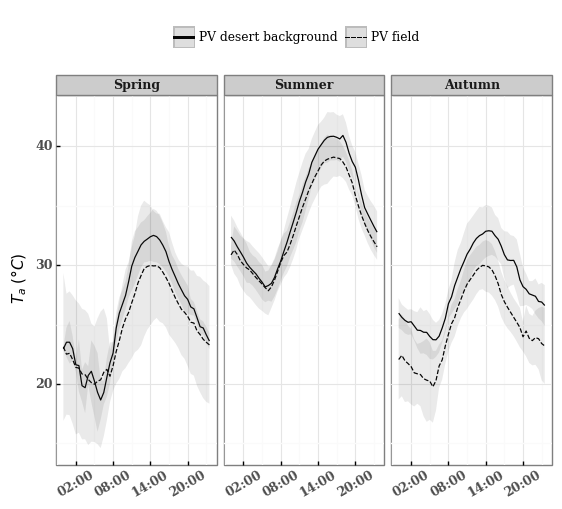

<ggplot: (-9223371892144025220)>

In [9]:
diurnal_df['timestamp2'] = pd.to_datetime(diurnal_df['Time'], utc=True)
diurnal_df = diurnal_df.loc[diurnal_df['Ecosystem'].isin(['PV field', 'PV desert background'])].copy()

plt = ggplot(diurnal_df)
plt = plt + geom_line(aes(x='timestamp2', y='Ta_mean',linetype='Ecosystem'))
plt = plt + geom_ribbon(aes(x='timestamp2', ymin='Ta_mean - Ta_std', ymax='Ta_mean + Ta_std', linetype='Ecosystem'), alpha=0.1)
plt = plt + labs(x='Hour', y='$T_a \;(°C)$', parse=True)
plt = plt + facet_wrap(['Season'])
plt = plt + theme_bw()
plt = plt + theme(axis_text_x=element_text(size=9,rotation=30,hjust=0.5,weight='bold'),
                  axis_title_x = element_blank(),
                  axis_text_y=element_text(size=9,weight='bold'),
                  strip_text=element_text(size=9,weight='bold'),
                  legend_title=element_blank(),
                  text=element_text(family="serif"), axis_ticks_direction_y='in', axis_ticks_direction_x='in')
plt = plt + theme(legend_position = 'top')
plt = plt + scale_x_datetime(date_breaks = '6 hours', date_labels = '%H:%M')

#plt.save(graphs_path + 'temperature_diurnal.pdf', width=20, height=10, units='cm', scale=1.3, dpi=600)
#plt.save(graphs_path + 'temperature_diurnal.png', width=20, height=10, units='cm', scale=1.3, dpi=600)


plt

## Graph Lout

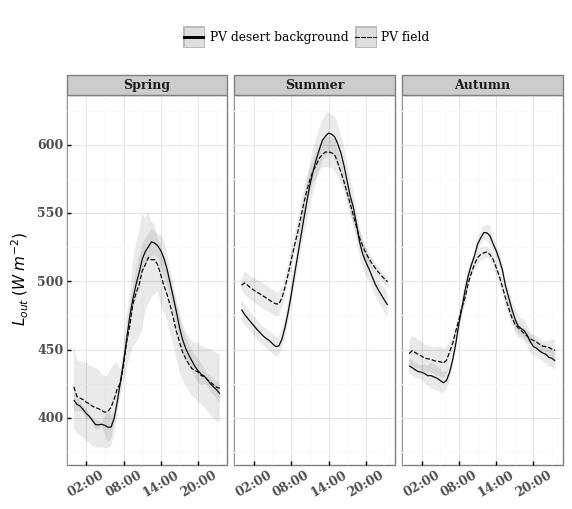

<ggplot: (-9223371877437052148)>

In [36]:
diurnal_df['timestamp2'] = pd.to_datetime(diurnal_df['Time'], utc=True)
diurnal_df = diurnal_df.loc[diurnal_df['Ecosystem'].isin(['PV field', 'PV desert background'])].copy()

plt = ggplot(diurnal_df)
plt = plt + geom_line(aes(x='timestamp2', y='Lout_mean',linetype='Ecosystem'))
plt = plt + geom_ribbon(aes(x='timestamp2', ymin='Lout_mean - Lout_std', ymax='Lout_mean + Lout_std', linetype='Ecosystem'), alpha=0.1)
plt = plt + labs(x='Hour', y='$L_{out} \;(W \;m^{-2})$', parse=True)
plt = plt + facet_wrap(['Season'])
plt = plt + theme_bw()
plt = plt + theme(axis_text_x=element_text(size=9,rotation=30,hjust=0.5,weight='bold'),
                  axis_title_x = element_blank(),
                  axis_text_y=element_text(size=9,weight='bold'),
                  strip_text=element_text(size=9,weight='bold'),
                  legend_title=element_blank(),
                  text=element_text(family="serif"), axis_ticks_direction_y='in', axis_ticks_direction_x='in')
plt = plt + theme(legend_position = 'top')
plt = plt + scale_x_datetime(date_breaks = '6 hours', date_labels = '%H:%M')

#plt.save(graphs_path + 'temperature_diurnal.pdf', width=20, height=10, units='cm', scale=1.3, dpi=600)
#plt.save(graphs_path + 'temperature_diurnal.png', width=20, height=10, units='cm', scale=1.3, dpi=600)


plt

## Graph Lin

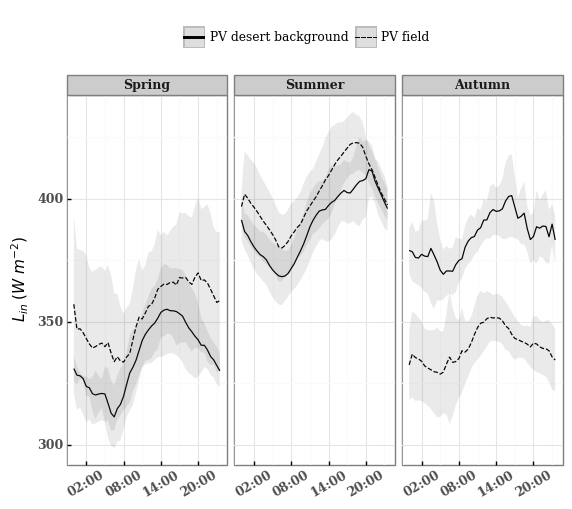

<ggplot: (-9223371877437103468)>

In [37]:
diurnal_df['timestamp2'] = pd.to_datetime(diurnal_df['Time'], utc=True)
diurnal_df = diurnal_df.loc[diurnal_df['Ecosystem'].isin(['PV field', 'PV desert background'])].copy()

plt = ggplot(diurnal_df)
plt = plt + geom_line(aes(x='timestamp2', y='Lin_mean',linetype='Ecosystem'))
plt = plt + geom_ribbon(aes(x='timestamp2', ymin='Lin_mean - Lin_std', ymax='Lin_mean + Lin_std', linetype='Ecosystem'), alpha=0.1)
plt = plt + labs(x='Hour', y='$L_{in} \;(W \;m^{-2})$', parse=True)
plt = plt + facet_wrap(['Season'])
plt = plt + theme_bw()
plt = plt + theme(axis_text_x=element_text(size=9,rotation=30,hjust=0.5,weight='bold'),
                  axis_title_x = element_blank(),
                  axis_text_y=element_text(size=9,weight='bold'),
                  strip_text=element_text(size=9,weight='bold'),
                  legend_title=element_blank(),
                  text=element_text(family="serif"), axis_ticks_direction_y='in', axis_ticks_direction_x='in')
plt = plt + theme(legend_position = 'top')
plt = plt + scale_x_datetime(date_breaks = '6 hours', date_labels = '%H:%M')

#plt.save(graphs_path + 'temperature_diurnal.pdf', width=20, height=10, units='cm', scale=1.3, dpi=600)
#plt.save(graphs_path + 'temperature_diurnal.png', width=20, height=10, units='cm', scale=1.3, dpi=600)


plt

## Graph Energy Fluxes

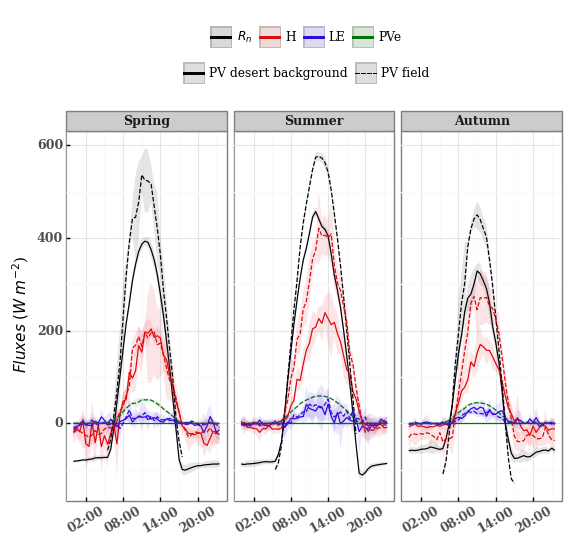

<ggplot: (-9223371877434513520)>

In [40]:
cbPalette = ["#02000B","#DE090F","#2D09DE", "#037209", "#80ff80", "#c2c2d6", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

# Convert the times back to a “fake” timestamp:
diurnal_df['timestamp2'] = pd.to_datetime(diurnal_df['Time'], utc=True)
diurnal_df = diurnal_df.loc[diurnal_df['Ecosystem'].isin(['PV field', 'PV desert background'])].copy()

# Makes long format
temp_means = pd.melt(diurnal_df, id_vars=['Ecosystem','Season','Time','timestamp2'], value_vars=['H_mean','LE_mean','PVe_mean','Rn_mean'])
temp_sds = pd.melt(diurnal_df, id_vars=['Ecosystem','Season','Time','timestamp2'], value_vars=['H_std','LE_std','PVe_std','Rn_std'])

temp_means.rename(columns={'value': 'mean'}, inplace=True)
temp_sds.rename(columns={'value': 'std'}, inplace=True)

temp_means['variable'] = temp_means['variable'].astype(str).str.replace('_mean', '')
temp_sds['variable'] = temp_means['variable'].astype(str).str.replace('_std', '')

temp = temp_means.merge(temp_sds, on=['Ecosystem','Season','Time','timestamp2','variable'])

temp.loc[temp['variable'] == 'Rn', 'variable'] = '$R_n$'


plt = ggplot(temp)
plt = plt + geom_line(aes(x='timestamp2', y='mean',linetype='Ecosystem', color='variable'))
#plt = plt + geom_line(aes(x='timestamp2', y='LE_mean',linetype='Ecosystem'), colour='#234566')
plt = plt + geom_ribbon(aes(x='timestamp2', ymin='mean - std', ymax='mean + std',linetype='Ecosystem', fill='variable'), alpha=0.1)
plt = plt + labs(x='Hour', y='$Fluxes\; (W \; m^{-2}$)', parse=True)
plt = plt + facet_wrap(['Season'])
plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + theme_bw()
plt = plt + theme(axis_text_x=element_text(size=9,rotation=30,hjust=0.5,weight='bold'),
                  axis_title_x = element_blank(),
                  axis_text_y=element_text(size=9,weight='bold'),
                  strip_text=element_text(size=9,weight='bold'),
                  legend_title=element_blank(),
                  text=element_text(family="serif"), axis_ticks_direction_y='in', axis_ticks_direction_x='in')
plt = plt + theme(legend_position = 'top')
#plt = plt + theme(legend_title = 'none')
plt = plt + scale_x_datetime(date_breaks = '6 hours', date_labels = '%H:%M')

#plt.save(graphs_path + 'energy_budget.pdf', width=19, height=7, units='cm', scale=1.3, dpi=600)
#plt.save(graphs_path + 'energy_budget.png', width=19, height=7, units='cm', scale=1.3, dpi=600)


plt

## t-tests comparing Rn with H_LE_PVe

In [16]:
# Do averaging of the days, and then continue
daily_df = df.groupby(['Season','Ecosystem','Day']).mean()
daily_df.reset_index(inplace=True)
display(daily_df.loc[daily_df['Season'] == 'Summer'])
# Do a t-test of Rn vs H_LE_PVe in each season and ecosystem separately
p_df = ttest_2vars(df, ['Season', 'Ecosystem'], ['Rn','H_LE_PVe'])
# Merge the means and the P values, only using relevant columns
mean_daily_p_df = mean_daily_df[['Season', 'Ecosystem', 'Rn','H_LE_PVe']].merge(p_df, how='outer', on=['Season','Ecosystem'])
# Show results
display(mean_daily_p_df)

,Season,Ecosystem,Day,Year,H,LE,Pa,RH,TA_merge,VPD,...,Lemitted,emissivity,PVe,Rn,Ts,D_T,cp,rho,rH,H_LE_PVe
511,Summer,Afforestation,2013-08-01,2013,165.143750,13.415147,93364.832896,NaN,NaN,NaN,...,428.425991,NaN,0.000000,251.893097,31.680831,4.686520,1013.066774,1.049392,121.162237,178.558897
512,Summer,Afforestation,2013-08-02,2013,154.506250,2.058095,93344.763625,NaN,NaN,NaN,...,417.876833,NaN,0.000000,177.935419,29.746403,3.351368,1012.068017,1.052891,-30.606132,156.564345
513,Summer,Afforestation,2013-08-03,2013,170.847917,19.880184,93386.431812,NaN,NaN,NaN,...,408.886805,NaN,0.000000,187.241668,28.117905,3.696708,1016.538204,1.070324,inf,190.728100
514,Summer,Afforestation,2013-08-04,2013,170.331250,23.271274,93300.554000,NaN,NaN,NaN,...,403.444403,NaN,0.000000,185.031251,27.154850,3.777662,1017.766925,1.077045,139.043914,193.602524
515,Summer,Afforestation,2013-08-05,2013,198.662500,22.424067,93205.719917,NaN,NaN,NaN,...,410.344351,NaN,0.000000,192.527088,28.378100,3.594333,1017.100938,1.066695,-2.391647,221.086567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790,Summer,PV field,2019-07-19,2019,124.844227,12.582057,99661.241667,36.714792,306.457292,3374.702292,...,471.673309,0.85,20.264181,305.092232,41.196349,7.889051,1016.176634,1.087253,5516.667389,157.690466
791,Summer,PV field,2019-07-20,2019,126.607142,15.441549,99654.802083,38.618333,305.425000,3156.777917,...,468.385717,0.85,20.111810,299.698852,40.628376,8.353370,1015.864917,1.093633,7144.920115,162.160502
792,Summer,PV field,2019-07-21,2019,136.681760,14.160485,99550.145833,42.728125,304.601875,2835.965208,...,464.435979,0.85,20.133996,305.458565,39.975182,8.523303,1016.443968,1.098625,-1464.756663,170.976241
793,Summer,PV field,2019-07-22,2019,126.393590,9.519597,99318.139583,37.632708,306.251042,3354.398750,...,467.419806,0.85,19.808745,305.421376,40.492183,7.391137,1016.203818,1.084451,306.947434,155.721932


,Season,Ecosystem,Rn,H_LE_PVe,P
0,Autumn,Afforestation,88 (59),103 (41),<.001
1,Autumn,PV desert background,40 (6),45 (8),0.3
2,Autumn,PV field,193 (10),70 (12),<.05
3,Spring,Afforestation,116 (85),103 (56),0.38
4,Spring,Afforestation desert background,77 (42),66 (29),<.001
5,Spring,PV desert background,54 (2),39 (8),0.08
6,Spring,PV field,257 (31),60 (16),<.001
7,Summer,Afforestation,172 (47),180 (39),<.001
8,Summer,Afforestation desert background,87 (58),77 (31),<.001
9,Summer,PV desert background,100 (25),77 (19),<.01
